# Routing around obstacles

In [1]:
from shapely.geometry import Polygon, LineString, Point
from matplotlib import pyplot as plt
import string

In [2]:
# straight path
line = LineString([(0, 2), (3, 2)])

# large obstacle which is touched by the straight path
poly_0 = Polygon([(1, 1), (1.5, 2.5), (2, 1), (2, 3), (1, 3), (1, 1)])

# small obstacle which just further complicates stuff
poly_1 = Point(1.5, 2.15).buffer(0.03)

In [3]:
all_points = set()

# original objects
all_points = all_points.union(set(list(zip(*poly_0.exterior.xy))))
all_points = all_points.union(set(list(zip(*line.xy))))

# intersection points
for n, g in enumerate(poly_0.difference(line.buffer(0.001)).geoms):
    all_points = all_points.union(set(list(zip(*g.exterior.xy))))

# round to get rid of degenerate points
all_points = set(map(lambda p: tuple(map(lambda t: round(t, 2), p)), all_points))

# sort from lower left corder to upper right corner
all_points = sorted(all_points)

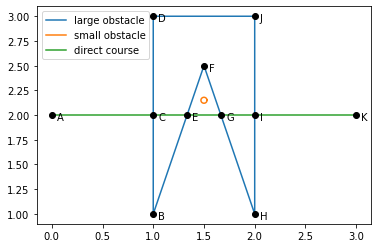

In [4]:
plt.plot(*poly_0.exterior.xy, label="large obstacle")
plt.plot(*poly_1.exterior.xy, label="small obstacle")
plt.plot(*line.xy, label="direct course")

for lab, p in zip(string.ascii_uppercase, all_points):
    plt.plot(*p, 'ko')
    plt.annotate(
        lab,
        xy=p, xycoords='data',
        xytext=(5, -5), textcoords='offset points',
    )    

plt.legend(loc=2);

## Automatically solving the graph

In [5]:
import networkx

In [6]:
g = networkx.MultiGraph()

## Construct graph by defining all edges

We'll add keys indicating the points belonging to the edge and whether tha path is over land or through water.

In [7]:
g.add_edge("A", "C", key=("AC", "water"))

g.add_edge("C", "E", key=("CBE", "water"))
g.add_edge("C", "E", key=("CE", "land"))

g.add_edge("E", "G", key=("EG", "water"))
g.add_edge("E", "G", key=("EFG", "water"))

g.add_edge("G", "I", key=("GHI", "water"))
g.add_edge("G", "I", key=("GI", "land"))

g.add_edge("C", "I", key=("CDJI", "water"))

g.add_edge("I", "K", key=("IK", "water"));

Note that here all that is needed is that the start and end and the key is hashable. So with hashable types for shapely `Point` and `LineString`, we could directly use them here.

## Remove edges which touch land

In [8]:
def is_land_edge(edge):
    return edge[2][1] == "land"

In [9]:
land_edges = list(filter(is_land_edge, g.edges))
g.remove_edges_from(land_edges)

## Show remaining graph

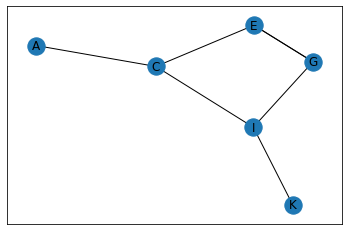

In [10]:
networkx.draw_networkx(g)

In [11]:
display(list(g.edges))

[('A', 'C', ('AC', 'water')),
 ('C', 'E', ('CBE', 'water')),
 ('C', 'I', ('CDJI', 'water')),
 ('E', 'G', ('EG', 'water')),
 ('E', 'G', ('EFG', 'water')),
 ('G', 'I', ('GHI', 'water')),
 ('I', 'K', ('IK', 'water'))]

## Find all paths from start to end (A to K)

In [12]:
for p in networkx.all_simple_edge_paths(g, "A", "K"):
    print(list(map(lambda _p: _p[2][0], p)))

['AC', 'CBE', 'EG', 'GHI', 'IK']
['AC', 'CBE', 'EFG', 'GHI', 'IK']
['AC', 'CDJI', 'IK']
